# Bi-variate analysis using Liana+

## Generate anndata object from Molkart output

In [61]:
from numpy.random import default_rng
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np

import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix


sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
import warnings
warnings.filterwarnings('ignore')

li.__version__


scanpy==1.9.4 anndata==0.10.4 umap==0.5.3 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10
squidpy==1.3.1


'1.0.4'

In [2]:
## Read in counts and coordinates
import pandas as pd

# Read in spatial data
metadata = pd.read_csv('../../output/molkart/harmony_object.metadata_anndata.tsv', index_col=False, sep= "\t")
centroids_groups = {name: group[['X_centroid', 'Y_centroid']].to_numpy() for name, group in metadata.groupby('sample_ID')}
# Please mirror the centroid_groups by the y-axis to match the coordinates of the image
for key, value in centroids_groups.items():
    value[:,1] = 1000 - value[:,1]

counts = pd.read_csv('../../output/molkart/harmony_object.counts_anndata.tsv', index_col=False, sep= "\t")
counts_groups = {name: csr_matrix(counts.loc[group.index].to_numpy()) for name, group in metadata.groupby('sample_ID')}

cell_types_groups = {name: group[['seurat_clusters', 'anno_cell_type_lvl1','anno_cell_type_lvl2','anno_cell_type_lvl3','liana_cts']] for name, group in metadata.groupby('sample_ID')}

In [3]:
## Generate an anndata object for each sample
anndata_objects = {name: ad.AnnData(counts_groups[name], 
                                    obsm={"spatial": centroids_groups[name]}) for name in metadata['sample_ID'].unique()}
## Set gene names
for name in anndata_objects.keys():
    anndata_objects[name].var_names = counts.columns
    metadata_subset = metadata[metadata['sample_ID'] == name]
    # Now use the row index from metadata_subset to subset the counts
    anndata_objects[name].layers['counts'] = counts.loc[metadata_subset.index].to_numpy()
    sc.pp.normalize_total(anndata_objects[name], target_sum=1e4)
    #sc.pp.log1p(adata)

## Set metadata
for name in anndata_objects.keys():
    anndata_objects[name].obs = cell_types_groups[name]
    anndata_objects[name].obs.index = anndata_objects[name].obs.index.astype(str)

In [4]:
anndata_objects.keys()

dict_keys(['sample_2d_r1_s1', 'sample_2d_r2_s1', 'sample_4d_r1_s1', 'sample_4d_r2_s1', 'sample_4h_r1_s1', 'sample_4h_r2_s2', 'sample_control_r1_s1', 'sample_control_r2_s1'])

In [ ]:
# sc.pl.spatial(anndata_objects['sample_2d_r1_s1'], color=['Nppa', 'Nppb'],spot_size = 150,
#               size=1.4, ncols=2)

## Run Liana+ bi-variate analysis on one hot encoded cell-types

In [70]:
chosen_bandwith = 724 * 1.5
#chosen_bandwith = 724*2 ## 200 um
#chosen_bandwith = 724/2 ## 50 um
chosen_cutoff = 0.1

### Control

In [77]:
sample = "sample_control_r1_s1"

adata_control = anndata_objects[sample]
# Make the x axis the y axis and vice versa
# adata_control.obsm['spatial'][:,[0,1]] = adata_control.obsm['spatial'][:,[1,0]]
# adata_control.obsm['spatial'][:,1] = 1000 - adata_control.obsm['spatial'][:,1]

cell_type_names = adata_control.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata_control.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata_control = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata_control.obs.copy(),
                obsm=adata_control.obsm.copy(),
                uns=adata_control.uns.copy(),)

li.ut.spatial_neighbors(adata_control, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)


adata_control = adata_control

li.mt.lr_bivar(adata_control,
            function_name='product', # Name of the function
            n_perms=None, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata_control.obsm['local_scores']

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 9 self-interactions


... storing 'anno_cell_type_lvl1' as categorical
... storing 'anno_cell_type_lvl2' as categorical
... storing 'anno_cell_type_lvl3' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


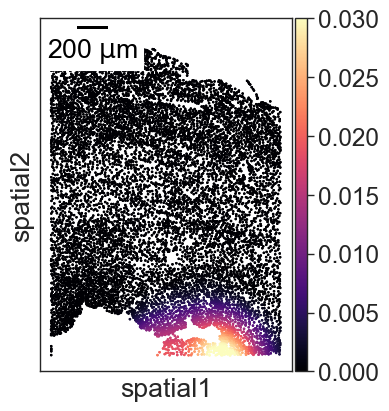

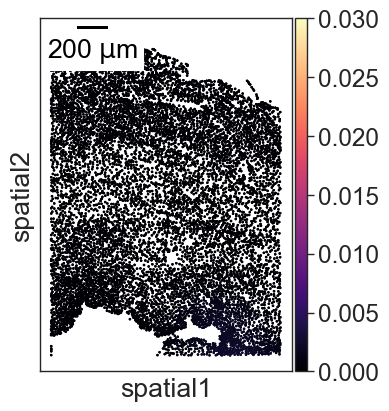

In [78]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial cells^Cardiomyocytes Nppa+",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    scalebar_dx=0.138,
    scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
    vmin=0, vmax=0.03

)

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.control.endo_nppa.pdf", bbox_inches='tight')

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial cells^Myeloid cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    scalebar_dx=0.138,
    scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
    vmin=0, vmax=0.03

)

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.control.endo_myeloid.pdf", bbox_inches='tight')

### 2 day sample

In [81]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

sample = "sample_2d_r2_s1"
adata = anndata_objects[sample]
cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)

adata_2d = adata

li.mt.lr_bivar(adata,
            function_name='product', # Name of the function
            n_perms=None, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata_2d.obsm['local_scores']

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 9 self-interactions


... storing 'anno_cell_type_lvl1' as categorical
... storing 'anno_cell_type_lvl2' as categorical
... storing 'anno_cell_type_lvl3' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


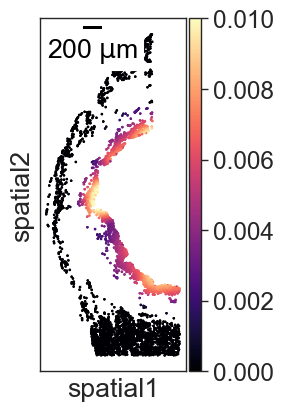

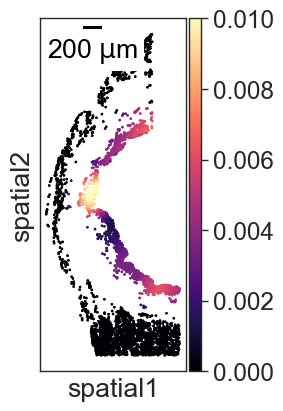

In [82]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial cells^Cardiomyocytes Nppa+",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    vmin = 0, vmax = 0.01,
    scalebar_dx=0.138,
    scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.2d.endo_nppa.pdf", bbox_inches='tight')

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial cells^Myeloid cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    vmin = 0, vmax = 0.01,
    scalebar_dx=0.138,
    scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)
## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.2d.endo_myeloid.pdf", bbox_inches='tight')

### d4 sample

In [83]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

sample = "sample_4d_r1_s1"
adata = anndata_objects[sample]
cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)

li.mt.lr_bivar(adata,
            function_name='product', # Name of the function
            n_perms=None, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']

adata_d4 = adata

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 9 self-interactions


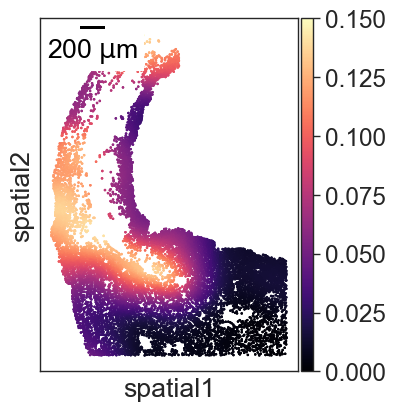

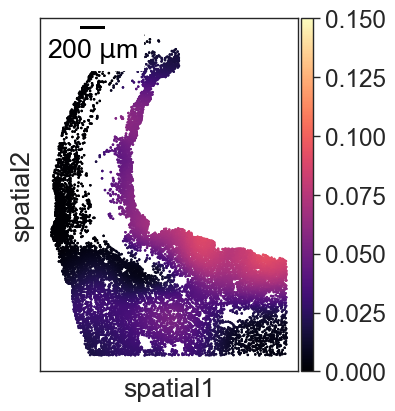

In [85]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiac fibroblasts^Myeloid cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    vmin = 0, vmax = 0.15,
    scalebar_dx=0.138,
    scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)

#plt.show()

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.4d.cfib_myeloid.pdf", bbox_inches='tight', dpi=300)

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiomyocytes Nppa+^Myeloid cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    vmin = 0, vmax = 0.15,
    scalebar_dx=0.138,
    scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)

#plt.show()

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.4d.nppa_myeloid.pdf", bbox_inches='tight', dpi=300)

## Calculate distances between different cell types

### Endokard - Myeloid cells

                  sum_sq     df           F        PR(>F)
timepoint  269823.581595    2.0  289.667194  6.539067e-88
Residual   269667.841199  579.0         NaN           NaN
                   2d            4d       control
2d       1.000000e+00  1.808492e-01  4.043270e-78
4d       1.808492e-01  1.000000e+00  5.522265e-22
control  4.043270e-78  5.522265e-22  1.000000e+00


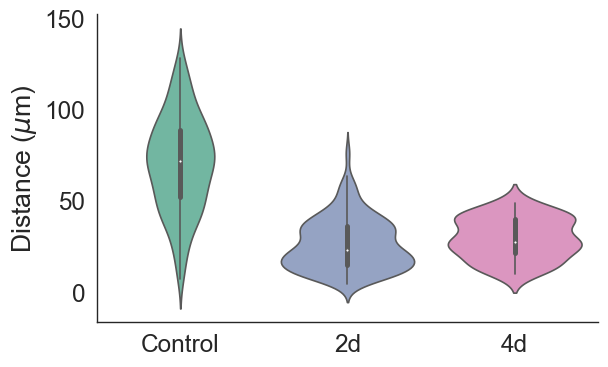

In [53]:
import seaborn as sns

plot_size_factor = 4

##### control calculations
ndist_neighbours = 3
endo_distances_dict = {}
# Get the color palette
palette = sns.color_palette('Set2')
# Select the first, third, and fourth elements
selected_colors = [palette[i] for i in [0, 2, 3]]

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called endo_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
        endo_cells = adata.obs['liana_cts'] == 'Endocardial cells'
        endo_cells = adata.obsm['spatial'][endo_cells]

        myeloid_cells = adata.obs['liana_cts'] == 'Myeloid cells'
        myeloid_cells = adata.obsm['spatial'][myeloid_cells]

        from scipy.spatial import distance
        endo_distances = distance.cdist(endo_cells, myeloid_cells, 'euclidean')
        # Transform the distances from pixel into micrometer by multiplying with 0.138
        endo_distances = endo_distances * 0.138

        # For each row in endo_distances, keep only the 10 smallest values and remove the other values from the array
        endo_distances = np.array([np.sort(row)[:ndist_neighbours] for row in endo_distances])
        # Flatten the array
        endo_distances = endo_distances.flatten()

        # Check if timepoint already exists and if so, append the values to the existing dict
        if timepoint in endo_distances_dict.keys():
            endo_distances_dict[timepoint] = np.append(endo_distances_dict[timepoint], endo_distances)
        else:
            endo_distances_dict[timepoint] = endo_distances


import statsmodels.api as sm
from statsmodels.formula.api import ols
# Convert endo_distances_dict into a pandas data frame with column 'distance' and 'timepoint'
endo_distances_df = pd.DataFrame({'distance': np.concatenate(list(endo_distances_dict.values())),
                                    'timepoint': np.concatenate([[key] * len(value) for key, value in endo_distances_dict.items()])})
# Use sm.stats.anova_lm to perform anova on endo_distances_df
aov_table = sm.stats.anova_lm(ols('distance ~ timepoint', data=endo_distances_df).fit(), typ=2)
print(aov_table)

import scikit_posthocs as sp
t_tests = sp.posthoc_ttest(endo_distances_df, val_col='distance', group_col='timepoint', p_adjust='holm')
print(t_tests)

# Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
endo_distances_dict = {key: endo_distances_dict[key] for key in ['control', '2d', '4d']}

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(plot_size_factor*1.618,plot_size_factor))
# Take the first, third and fourth color from the color palette 'Set2' in seaborn

# Plot the violin plots
sns.violinplot(data = list(endo_distances_dict.values()), palette=selected_colors, ax=ax, alpha = 1)
# Add a stripplot on top of the violin plots
#sns.stripplot(data = list(endo_distances_dict.values()), color="black", alpha=0.5, ax=ax,jitter=True)

# Plot data points on top of violin plots. Each data point should be a measurement from one cell
#sns.swarmplot(data = list(endo_distances_dict.values()), color="black", alpha=0.5)

# Rename the x axis labels to control, 2d, 4d
plt.xticks([0, 1, 2], ['Control', '2d', '4d'])

# Remove the black border of the plottng area
sns.despine()
# Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
plt.ylabel('Distance ($\mu$m)')

plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.endocard_myeloid.pdf", bbox_inches='tight')

### Cardiac Fibroblasts - Myeloid cells

                 sum_sq       df            F  PR(>F)
timepoint  3.826846e+06      2.0  3810.317951     0.0
Residual   1.323014e+07  26346.0          NaN     NaN
                    2d   4d        control
2d        1.000000e+00  0.0  9.053968e-256
4d        0.000000e+00  1.0   0.000000e+00
control  9.053968e-256  0.0   1.000000e+00


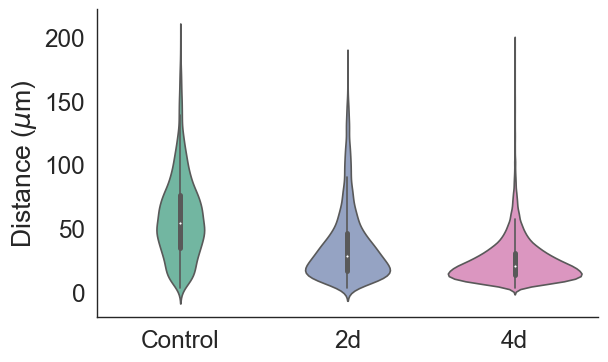

In [58]:
##### control calculations
ndist_neighbours = 3
endo_distances_dict = {}

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
        cfib_cells = adata.obs['liana_cts'] == 'Cardiac fibroblasts'
        cfib_cells = adata.obsm['spatial'][cfib_cells]

        myeloid_cells = adata.obs['liana_cts'] == 'Myeloid cells'
        myeloid_cells = adata.obsm['spatial'][myeloid_cells]

        from scipy.spatial import distance
        distances = distance.cdist(cfib_cells,myeloid_cells, 'euclidean')
        # Transform the distances from pixel into micrometer by multiplying with 0.138
        distances = distances * 0.138

        # For each row in distances, keep only the 10 smallest values and remove the other values from the array
        distances = np.array([np.sort(row)[:ndist_neighbours] for row in distances])
        # Flatten the array
        distances = distances.flatten()

        # Check if timepoint already exists and if so, append the values to the existing dict
        if timepoint in endo_distances_dict.keys():
            endo_distances_dict[timepoint] = np.append(endo_distances_dict[timepoint], distances)
        else:
            endo_distances_dict[timepoint] = distances


import statsmodels.api as sm
from statsmodels.formula.api import ols
# Convert endo_distances_dict into a pandas data frame with column 'distance' and 'timepoint'
endo_distances_df = pd.DataFrame({'distance': np.concatenate(list(endo_distances_dict.values())),
                                    'timepoint': np.concatenate([[key] * len(value) for key, value in endo_distances_dict.items()])})
# Use sm.stats.anova_lm to perform anova on endo_distances_df
aov_table = sm.stats.anova_lm(ols('distance ~ timepoint', data=endo_distances_df).fit(), typ=2)
print(aov_table)

import scikit_posthocs as sp
t_tests = sp.posthoc_ttest(endo_distances_df, val_col='distance', group_col='timepoint', p_adjust='holm')
print(t_tests)

# Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
endo_distances_dict = {key: endo_distances_dict[key] for key in ['control', '2d', '4d']}

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(plot_size_factor*1.618,plot_size_factor))
sns.violinplot(data = list(endo_distances_dict.values()), palette=selected_colors, ax=ax, alpha = 1)
# Plot boxplot instead of violin plot
#sns.boxplot(data = list(endo_distances_dict.values()))
# Rename the x axis labels to control, 2d, 4d
plt.xticks([0, 1, 2], ['Control', '2d', '4d'])
#plt.title('Cardiac fibroblasts')
# Remove the black border of the plottng area
sns.despine()
# Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
plt.ylabel('Distance ($\mu$m)')
plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.cfib_myeloid.pdf", bbox_inches='tight')

### Endothelial cells - Myeloid cells

Text(0, 0.5, 'Distance to ($\\mu$m)')

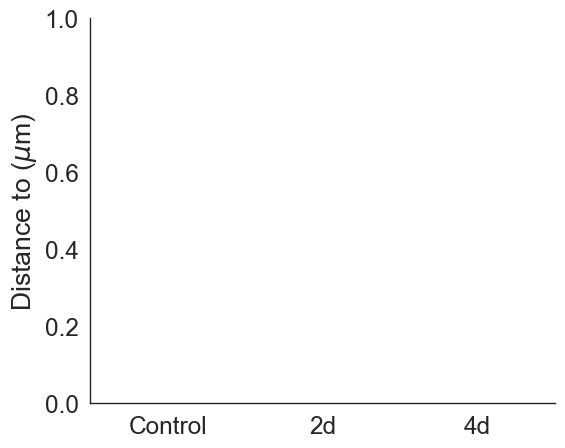

In [37]:
# ##### control calculations
# ndist_neighbours = 3
# distances_dict = {}

# # Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called distances
# for sample in anndata_objects.keys():
#     # Get the timepoint from the sample name
#     timepoint = sample.split('_')[1]
#     adata = anndata_objects[sample]
#     # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
#     endot_cells = adata.obs['liana_cts'] == 'Endothelial_cells'
#     endot_cells = adata.obsm['spatial'][endot_cells]

#     myeloid_cells = adata.obs['liana_cts'] == 'Myeloid_cells'
#     myeloid_cells = adata.obsm['spatial'][myeloid_cells]

#     from scipy.spatial import distance
#     distances = distance.cdist(endot_cells,myeloid_cells, 'euclidean')
#     # Transform the distances from pixel into micrometer by multiplying with 0.138
#     distances = distances * 0.138

#     # For each row in distances, keep only the 10 smallest values and remove the other values from the array
#     distances = np.array([np.sort(row)[:ndist_neighbours] for row in distances])
#     # Flatten the array
#     distances = distances.flatten()

#     # Check if timepoint already exists and if so, append the values to the existing dict
#     if timepoint in distances_dict.keys():
#         distances_dict[timepoint] = np.append(distances_dict[timepoint], distances)
#     else:
#         distances_dict[timepoint] = distances

# # Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
# distances_dict = {key: distances_dict[key] for key in ['control', '2d', '4d']}

# sns.set_style('white')
# sns.set_context("paper", font_scale = 2)
# fig, ax = plt.subplots(figsize=(6,5))
# sns.violinplot(data = list(distances_dict.values()), palette=selected_colors, ax=ax, alpha = 1)
# # Plot boxplot instead of violin plot
# #sns.boxplot(data = list(endo_distances_dict.values()))
# # Rename the x axis labels to control, 2d, 4d
# plt.xticks([0, 1, 2], ['Control', '2d', '4d'])
# #plt.title('Cardiac fibroblasts')
# # Remove the black border of the plottng area
# sns.despine()
# # Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
# plt.ylabel('Distance to ($\mu$m)')
# #plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.cfib_myeloid.pdf", bbox_inches='tight')

### Endokardial cells to all other cell types

In [68]:
##### control calculations
ndist_neighbours = 3
distances_dict = {}

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called endo_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Calculate the distance between endo_cells and all other cell types in adata.obs['liana_cts'] 
        for ct in adata.obs['liana_cts'].unique():
            # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
            endo_cells = adata.obs['liana_cts'] == ct
            endo_cells = adata.obsm['spatial'][endo_cells]

            other_ct = adata.obs['liana_cts'] == 'Myeloid_cells'
            other_ct = adata.obsm['spatial'][other_ct]

            from scipy.spatial import distance
            endo_distances = distance.cdist(endo_cells, other_ct, 'euclidean')
            # Transform the distances from pixel into micrometer by multiplying with 0.138
            endo_distances = endo_distances * 0.138

            # For each row in endo_distances, keep only the X smallest values and remove the other values from the array
            endo_distances = np.array([np.sort(row)[:ndist_neighbours] for row in endo_distances])

            # Flatten the array
            #endo_distances = endo_distances.flatten()
            if ct in distances_dict.keys():
                if timepoint in distances_dict[ct].keys():
                    distances_dict[ct][timepoint] = np.append(distances_dict[ct][timepoint], endo_distances)
                else:
                    distances_dict[ct][timepoint] = endo_distances
            else:
                distances_dict[ct] = {}
                distances_dict[ct][timepoint] = endo_distances
        distances_dict.keys()

# for ct in distances_dict.keys():
#     # Set the order for the keys in distances_dict[ct].keys() to control, 2d, 4d
#     distances_dict[ct] = {key: distances_dict[ct][key] for key in ['control', '2d', '4d']}

#     sns.set_style('white')
#     sns.set_context("paper", font_scale = 2)
#     fig, ax = plt.subplots(figsize=(8,6))#
#     sns.violinplot(data = list(distances_dict[ct].values()), palette=selected_colors, ax=ax, alpha = 1)
    

#     # Plot data points on top of violin plots. Each data point should be a measurement from one cell
#     #sns.swarmplot(data = list(endo_distances_dict.values()), color="black", alpha=0.5)

#     # Rename the x axis labels to control, 2d, 4d
#     plt.xticks([0, 1, 2], ['Control', '2d', '4d'])
#     plt.title(ct)
#     # Remove the black border of the plottng area
#     sns.despine()
#     # Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
#     plt.ylabel('Distance ($\mu$m)')

#plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.endocard_myeloid.pdf", bbox_inches='tight')



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Myeloid_cells'),
  Text(1, 0, 'Cardiac_fibroblasts'),
  Text(2, 0, 'Pericytes'),
  Text(3, 0, 'Endothelial_cells'),
  Text(4, 0, 'Cardiomyocytes'),
  Text(5, 0, 'Smooth_muscle_cells'),
  Text(6, 0, 'Cardiomyocytes_Nppa+'),
  Text(7, 0, 'Endocardial_cells'),
  Text(8, 0, 'Lymphoid_cells')])

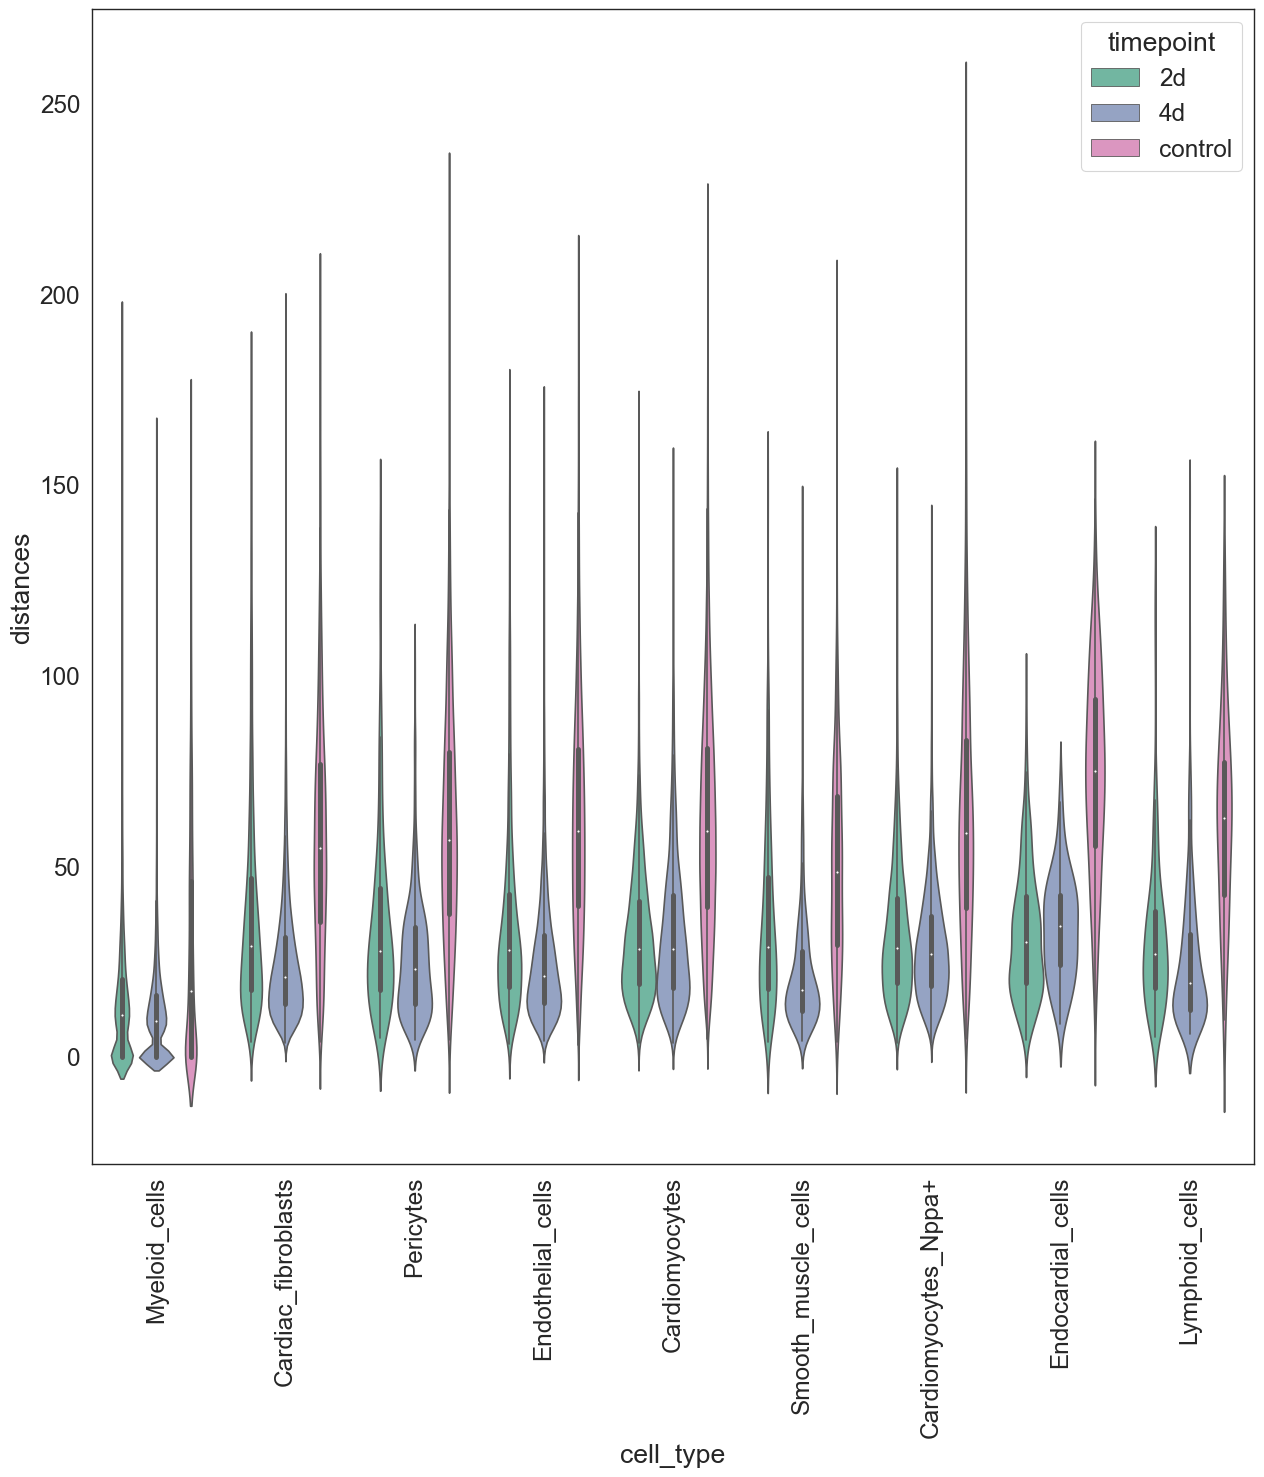

In [69]:
# Convert the contents from distances_dict into a pandas dataframe. Put the keys in distances_df into one column, the keys for each of the subdictionaries into another column and the values into a third column
distances_df = pd.DataFrame([(k, k2, v2) for k, v in distances_dict.items() for k2, v2 in v.items()], columns=['cell_type', 'timepoint', 'distances'])
# Modify distances_df so that each row contains the cell type, timepoint and distance to the closest myeloid cell for one cell
distances_df = distances_df.explode('distances')
# Subset for only timepoint d2 
# distances_df = distances_df[distances_df['timepoint'] == '2d']
# Keep only cell_types that can recruit myeloid cells : EndMA+, Endothelial_cells, 

# Convert the distances column from object to float
distances_df['distances'] = distances_df['distances'].astype(float)
# Plot the violin plot
sns.violinplot(data=distances_df, x="cell_type", y="distances", hue="timepoint", palette=selected_colors)
# Make plot bigger so all x axis labels are visible
plt.gcf().set_size_inches(15, 15)
# rotate x axis labels by 45 degrees
plt.xticks(rotation=90)

# Unused analysis

## Mesmer segmentation based cell-typing

In [24]:
from numpy.random import default_rng
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
import warnings
warnings.filterwarnings('ignore')
## Read in counts and coordinates
import pandas as pd

# Read in spatial data
metadata = pd.read_csv('../../output/molkart/mesmer_seg/harmony_object.metadata_anndata.tsv', index_col=False, sep= "\t")
centroids_groups = {name: group[['X_centroid', 'Y_centroid']].to_numpy() for name, group in metadata.groupby('sample_ID')}
# Please mirror the centroid_groups by the y-axis to match the coordinates of the image
for key, value in centroids_groups.items():
    value[:,1] = 1000 - value[:,1]

counts = pd.read_csv('../../output/molkart/mesmer_seg/harmony_object.counts_anndata.tsv', index_col=False, sep= "\t")
counts_groups = {name: csr_matrix(counts.loc[group.index].to_numpy()) for name, group in metadata.groupby('sample_ID')}

cell_types_groups = {name: group[['seurat_clusters','anno_cell_type_lvl2','liana_cts']] for name, group in metadata.groupby('sample_ID')}
## Generate an anndata object for each sample
anndata_objects = {name: ad.AnnData(counts_groups[name], 
                                    obsm={"spatial": centroids_groups[name]}) for name in metadata['sample_ID'].unique()}
## Set gene names
for name in anndata_objects.keys():
    anndata_objects[name].var_names = counts.columns
    metadata_subset = metadata[metadata['sample_ID'] == name]
    # Now use the row index from metadata_subset to subset the counts
    anndata_objects[name].layers['counts'] = counts.loc[metadata_subset.index].to_numpy()
    sc.pp.normalize_total(anndata_objects[name], target_sum=1e4)
    #sc.pp.log1p(adata)

## Set metadata
for name in anndata_objects.keys():
    anndata_objects[name].obs = cell_types_groups[name]
    anndata_objects[name].obs.index = anndata_objects[name].obs.index.astype(str)

scanpy==1.9.4 anndata==0.10.4 umap==0.5.3 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10
squidpy==1.3.1


### Control

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiac_fibroblasts_Il6+', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 13 self-interactions
100%|██████████| 10/10 [00:29<00:00,  2.92s/it]
... storing 'anno_cell_type_lvl2' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


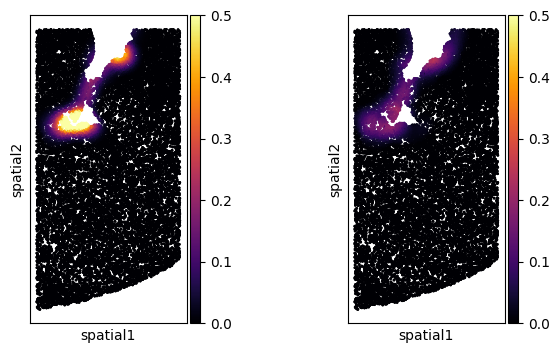

In [5]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

chosen_bandwith = 500
chosen_cutoff = 0.1

sample = "sample_control_r2_s1"
adata = anndata_objects[sample]
# Make the x axis the y axis and vice versa
adata.obsm['spatial'][:,[0,1]] = adata.obsm['spatial'][:,[1,0]]
adata.obsm['spatial'][:,1] = 1000 - adata.obsm['spatial'][:,1]

cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)
# sq.gr.spatial_neighbors(
#     adata,
#     n_neighs=150,
#     coord_type="generic",
#     delaunay=True,
# )
li.pl.connectivity(adata, idx=500, size=1)

adata_control = adata
li.mt.lr_bivar(adata,
            function_name='norm_product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+","Endocardial_cells^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="inferno",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    vmin=0, vmax=0.5
)

plt.show()


## Save this matplotlib plot as a pdf
#plt.savefig("../../plots/molkart.liana_plus.control.pdf", bbox_inches='tight')

### 2 day sample

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiac_fibroblasts_Il6+', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 13 self-interactions
100%|██████████| 10/10 [00:04<00:00,  2.24it/s]
... storing 'anno_cell_type_lvl2' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


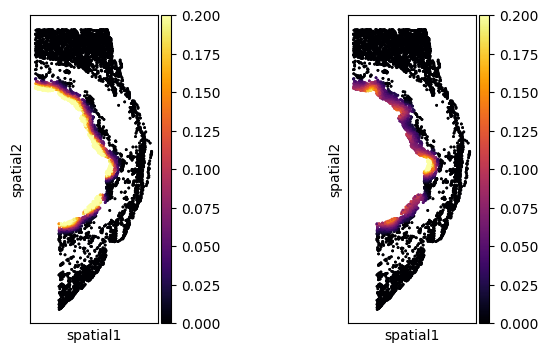

In [7]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

chosen_bandwith = 500
chosen_cutoff = 0.1

sample = "sample_2d_r2_s1"
adata = anndata_objects[sample]
# Make the x axis the y axis and vice versa
adata.obsm['spatial'][:,[0,1]] = adata.obsm['spatial'][:,[1,0]]
adata.obsm['spatial'][:,1] = 1000 - adata.obsm['spatial'][:,1]

cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)
# sq.gr.spatial_neighbors(
#     adata,
#     n_neighs=150,
#     coord_type="generic",
#     delaunay=True,
# )
li.pl.connectivity(adata, idx=500, size=1)

adata_control = adata
li.mt.lr_bivar(adata,
            function_name='norm_product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+","Endocardial_cells^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="inferno",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    vmin=0, vmax=0.2
)

plt.show()


## Save this matplotlib plot as a pdf
#plt.savefig("../../plots/molkart.liana_plus.control.pdf", bbox_inches='tight')

### 4 day sample

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiac_fibroblasts_Il6+', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 13 self-interactions
100%|██████████| 10/10 [00:36<00:00,  3.60s/it]
... storing 'anno_cell_type_lvl2' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


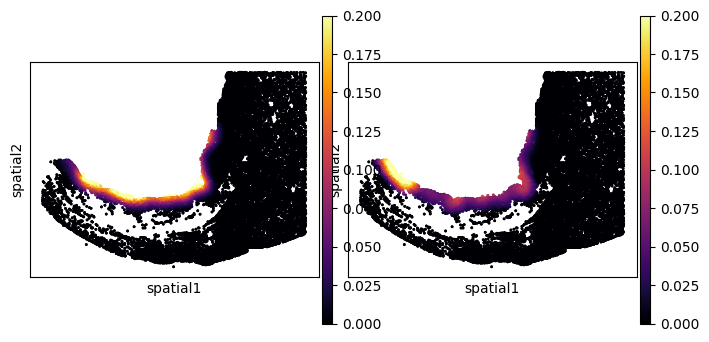

In [8]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

chosen_bandwith = 500
chosen_cutoff = 0.1

sample = "sample_4d_r1_s1"
adata = anndata_objects[sample]
# Make the x axis the y axis and vice versa
adata.obsm['spatial'][:,[0,1]] = adata.obsm['spatial'][:,[1,0]]
adata.obsm['spatial'][:,1] = 1000 - adata.obsm['spatial'][:,1]

cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)
# sq.gr.spatial_neighbors(
#     adata,
#     n_neighs=150,
#     coord_type="generic",
#     delaunay=True,
# )
li.pl.connectivity(adata, idx=500, size=1)

adata_control = adata
li.mt.lr_bivar(adata,
            function_name='norm_product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']

## Save this matplotlib plot as a pdf
#plt.savefig("../../plots/molkart.liana_plus.control.pdf", bbox_inches='tight')

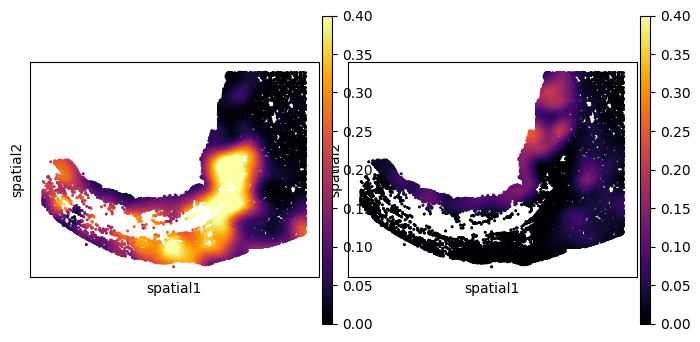

In [12]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiac_fibroblasts^Myeloid_cells","Cardiomyocytes_Nppa+^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="inferno",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    vmin=0, vmax=0.4
)

plt.show()

### Distances

Text(0, 0.5, 'Distance ($\\mu$m)')

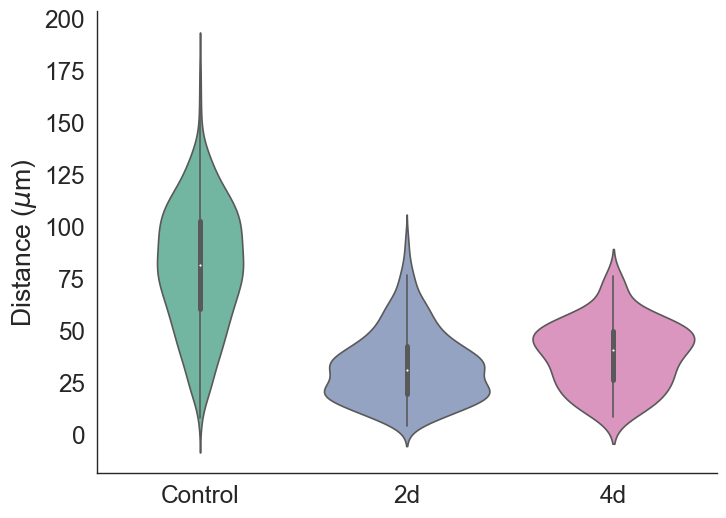

In [51]:
import seaborn as sns

##### control calculations
ndist_neighbours = 3
endo_distances_dict = {}
# Get the color palette
palette = sns.color_palette('Set2')
# Select the first, third, and fourth elements
selected_colors = [palette[i] for i in [0, 2, 3]]

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called endo_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
        endo_cells = adata.obs['liana_cts'] == 'Endocardial_cells'
        endo_cells = adata.obsm['spatial'][endo_cells]

        myeloid_cells = adata.obs['liana_cts'] == 'Myeloid_cells'
        myeloid_cells = adata.obsm['spatial'][myeloid_cells]

        from scipy.spatial import distance
        endo_distances = distance.cdist(endo_cells, myeloid_cells, 'euclidean')
        # Transform the distances from pixel into micrometer by multiplying with 0.138
        endo_distances = endo_distances * 0.138

        # For each row in endo_distances, keep only the 10 smallest values and remove the other values from the array
        endo_distances = np.array([np.sort(row)[:ndist_neighbours] for row in endo_distances])
        # Flatten the array
        endo_distances = endo_distances.flatten()

        # Check if timepoint already exists and if so, append the values to the existing dict
        if timepoint in endo_distances_dict.keys():
            endo_distances_dict[timepoint] = np.append(endo_distances_dict[timepoint], endo_distances)
        else:
            endo_distances_dict[timepoint] = endo_distances

# Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
endo_distances_dict = {key: endo_distances_dict[key] for key in ['control', '2d', '4d']}

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(8,6))
# Take the first, third and fourth color from the color palette 'Set2' in seaborn

# Plot the violin plots
sns.violinplot(data = list(endo_distances_dict.values()), palette=selected_colors, ax=ax, alpha = 1)

# Plot data points on top of violin plots. Each data point should be a measurement from one cell
#sns.swarmplot(data = list(endo_distances_dict.values()), color="black", alpha=0.5)

# Rename the x axis labels to control, 2d, 4d
plt.xticks([0, 1, 2], ['Control', '2d', '4d'])
#plt.title('Endocardial cells')
# Remove the black border of the plottng area
sns.despine()
# Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
plt.ylabel('Distance ($\mu$m)')

#plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.endocard_myeloid.pdf", bbox_inches='tight')

In [28]:
adata.obs['liana_cts'].unique()

array(['Pericytes', 'Cardiomyocytes', 'Endothelial_cells',
       'Cardiomyocytes_Nppb+', 'Myeloid_cells', 'Cardiac_fibroblasts',
       'Cardiomyocytes_Nppa+', 'Cardiac_fibroblasts_Il6+', 'EndMA+',
       'Smooth_muscle_cells', 'Epicardial_cells', 'Lymphoid_cells',
       'Endocardial_cells'], dtype=object)

## Squidpy analysis

In [ ]:
sq.pl.co_occurrence(
    adata,
    cluster_key="liana_cts",
    clusters="Endocardial_cells",
    figsize=(10, 5),
)

In [ ]:
sq.gr.spatial_autocorr(adata, mode="moran")
adata.uns["moranI"].head(10)

In [ ]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["Cardiomyocytes_Nppa+", "Endocardial_cells"],
    size=2,
    cmap = "inferno"
)

In [ ]:
sq.gr.centrality_scores(
    adata,
    cluster_key="liana_cts",
)
sq.pl.centrality_scores(adata, cluster_key="liana_cts", figsize=(20, 5), s=500)


In [ ]:
## Perform Squidpy analysis for all samples and save plots and results
samples_to_run = ["sample_2d_r1_s1","sample_2d_r2_s1",
        "sample_control_r1_s1","sample_control_r2_s1"]
for sample in samples_to_run:
    print(sample)
    adata = anndata_objects[sample]

    ## Calculate spatial enrichment
    sq.gr.spatial_neighbors(adata, coord_type="generic",radius=800)
    adata.obs['anno_cell_type_lv2'] = adata.obs['anno_cell_type_lv2'].astype('category')
    sq.gr.nhood_enrichment(adata, cluster_key="anno_cell_type_lv2")
    sq.pl.nhood_enrichment(adata, cluster_key="anno_cell_type_lv2", method="ward", figsize=(5, 5), dpi = 300,
                           palette="tab20",
                           save=f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.nhood_enrichment_plot.{sample}.png')

    ## Calculate spatial co-occurence
    sq.gr.co_occurrence(adata, cluster_key="anno_cell_type_lv2")
    ## Cardiomyocytes_Nppa+
    try:
        sq.pl.co_occurrence(
            adata,
            cluster_key="anno_cell_type_lv2",
            clusters="Cardiomyocytes_Nppa+",
            figsize=(15, 10),
            palette="tab20",
            save = f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.co_occurrence_plot.CMs_Nppa.{sample}.png'
        )
    except Exception as e:
        print(f"An error occurred with sample {sample}: {e}")
    ## Myeloid cells
    try:
        sq.pl.co_occurrence(
            adata,
            cluster_key="anno_cell_type_lv2",
            clusters="Myeloid_cells",
            figsize=(15, 10),
            palette="tab20",
            save = f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.co_occurrence_plot.Myeloid_cells.{sample}.png'
        )
    except Exception as e:
        print(f"An error occurred with sample {sample}: {e}")
    ## Endocardial cells
    try:
        sq.pl.co_occurrence(
            adata,
            cluster_key="anno_cell_type_lv2",
            clusters="Endocardial_cell",
            figsize=(15, 10),
            palette="tab20",
            save = f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.co_occurrence_plot.Endocardial_cells.{sample}.png'
     )
    except Exception as e:
        print(f"An error occurred with sample {sample}: {e}")

## Liana Plus

In [ ]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import decoupler as dc
import liana as li
import scanpy as sc
import squidpy as sq

from mudata import MuData

In [ ]:
from itertools import product
cell_type_names = adata.obs['anno_cell_type_lvl2'].unique()
combinations = list(product(cell_type_names, repeat=2))
combinations_list = list(combinations)
onehot_ct = pd.get_dummies(adata.obs['anno_cell_type_lvl2']).astype(int)
test = sc.AnnData(X=csr_matrix(onehot_ct),
                  var=pd.DataFrame(index=onehot_ct.columns),
                  obs=adata.obs.copy(),
                  obsm=adata.obsm.copy()
)
li.ut.spatial_neighbors(test, bandwidth=2000, cutoff=0.1, kernel='gaussian', set_diag=True)
li.pl.connectivity(test, idx=0, size=1.3)

li.mt.lr_bivar(test,
               function_name='jaccard', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.01, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               verbose=True,
               interactions = combinations_list)

In [ ]:
li.pl.connectivity(test, idx=0, size=1.3)

In [ ]:
lrdata = test.obsm['local_scores']
lrdata.uns['global_res'].sort_values("global_mean", ascending=False)
#lrdata.uns['global_res'].sort_values("global_sd", ascending=False)
#sc.pl.spatial(lrdata, color=['Cardiomyocytes_Nppa+^Endocardial_cell'], vmax=1, spot_size = 150)

In [ ]:
plot, _ = li.ut.query_bandwidth(coordinates=test.obsm['spatial'], start=0, end=500, interval_n=20)
plot + p9.scale_y_continuous(breaks=range(0, 500, 5))

In [ ]:
test.write('/Users/florian_wuennemann/Downloads/florian_test.lianaplus.h5ad')

In [ ]:
li.__version__